# Solving a 2D diffusion equation via the Finite Volume Method

## Introduction
This exercise considers the 2D flow in a square duct with sides of length $h$ = 0.1 m. The duct has no-slip walls aligned with the $x$ and $y$ axes, and the flow is out of the page in the $z$ direction. We assume the following information for this problem:

- The flow is steady, i.e. $\partial w / \partial t  = 0$
- The flow is aligned with the centreline of the duct, i.e. $\mathbf{u} = w(x,y)$, where $w$ is the component of $\mathbf{u}$ that is aligned with the $z$ coordinate
- The flow is fully developed, i.e. $\partial u / \partial z = 0$ and $dP / dz =$ constant
- The boundaries of the domain are solid, no-slip walls
- The fluid has dynamic viscosity of $\mu = 1 \times 10^{-3}$ Pa$\cdot$s and $\rho$ = 1 kg/m$^3$
- The pressure gradient is $d P /dz = -3.2$ Pa/m

The incompressible Navier-Stokes equations for the $w$ velocity component is
\begin{equation}
 \dfrac{\partial w}{\partial t} + u \dfrac{\partial w}{\partial x} + v \dfrac{\partial w}{\partial y} + w\dfrac{\partial w}{\partial z} = - \dfrac{\partial P}{\partial z} + \mu \left( \dfrac{\partial^2 w}{\partial x^2} + \dfrac{\partial^2 w}{\partial y^2} + \dfrac{\partial^2 w}{\partial z} \right). 
\end{equation}
As we apply the above assumptions to this problem, the whole left-hand disappears, leaving
\begin{equation}
 \mu \left( \dfrac{\partial^2 w}{\partial x^2} + \dfrac{\partial^2 w}{\partial y^2} \right) - \dfrac{d P}{d z} = 0.
\end{equation}
This is clearly a diffusion equation (e.g. elliptic PDE) for $w$ velocity. It can be more conveniently written in vector form as
\begin{equation}\label{eqn:ps}
\nabla \cdot ( \mu \nabla w) - \frac{ d P}{d z} = 0
\end{equation}
where $\nabla$ is the two-dimensional gradient operator,
\begin{equation}
\nabla = \dfrac{\partial}{\partial x} \mathbf{i} + \dfrac{\partial }{\partial y} \mathbf{j}. 
\end{equation}
We aim to numerically solve the diffusion equation above using the finite volume method to obtain the flow distribution in the square duct.

## Finite volume discretization

To begin, we will discretize the diffusion equation over a volume $\Omega$:
\begin{equation}
\int\limits_{\Omega} \nabla \cdot (\mu \nabla w) d\Omega - \int\limits_{\Omega} \dfrac{dP}{dz} d\Omega = 0.
\end{equation}

If we apply Gauss' divergence theory to first term on the left hand side, the volume integral can be converted to a surface integral over the faces of the control volume:

\begin{equation}
\boxed{\int\limits_{A} \mathbf{n} \cdot (\mu \nabla w) dA - \int\limits_{\Omega} \dfrac{dP}{dz} d\Omega = 0.}
\end{equation}

This equation is now in a form that we can discretize via the finite volume method (FVM). We will sub-divide the domain into a grid consisting of rectangular cells with centroids at $P$, $E$, $W$, $N$, $S$, etc. denoting the cell under consideration and its neighbours on all sides. The faces of the cell $P$ are denoted as $e$, $w$, $n$, and $s$.

First, let us integrate the first term in the boxed equation above:

\begin{equation}
\int\limits_{A} \mathbf{n} \cdot (\mu \nabla w) dA = \int\limits_{w}^{e} \mu \dfrac{\partial w}{\partial x} dy + \int\limits_{s}^{n} \mu \dfrac{\partial w}{\partial y} dx.
\end{equation}

Second, let us integrate the second term in the boxed equation above:

\begin{equation}
\int\limits_{\Omega} \dfrac{dP}{dz} d\Omega = \int\limits_s^n \int\limits_w^s \dfrac{\partial P}{\partial z} dy dx.
\end{equation}

Substituting these into the boxed equation yields:

\begin{equation}
\int\limits_{w}^{e} \mu \dfrac{\partial w}{\partial x} dy + \int\limits_{s}^{n} \mu \dfrac{\partial w}{\partial y} dx - \int\limits_s^n \int\limits_w^s \dfrac{\partial P}{\partial z} dy dx = 0.
\end{equation}

This is as far as we can go while retaining the exact equality in our governing equation. To proceed any further, we need to approximate the derivatives in our governing equation somehow. Let us use centered finite differences to approximate them as

\begin{equation}
\left( \dfrac{\partial w}{\partial x} \right)_e \approx \dfrac{w_E - w_P}{\Delta x} \\
\left( \dfrac{\partial w}{\partial x} \right)_w \approx \dfrac{w_P - w_W}{\Delta x} \\
\left( \dfrac{\partial w}{\partial y} \right)_n \approx \dfrac{w_N - w_P}{\Delta y} \\
\left( \dfrac{\partial w}{\partial y} \right)_s \approx \dfrac{w_P - w_S}{\Delta y} .
\end{equation}

Substituting these into our prior equation yields
\begin{equation}
\dfrac{\mu \Delta y}{\Delta x} (w_E - w_P) - \dfrac{\mu \Delta y}{\Delta x} (w_P - w_W) + \dfrac{\mu \Delta x}{\Delta y}(w_N - w_P) - \dfrac{\mu \Delta x}{\Delta y}(w_P - w_S) - \dfrac{dP}{dz}\Delta x \Delta y = 0,
\end{equation}

which we can simplify to 

\begin{equation}
\boxed{a_P w_P = a_E w_E + a_W w_W + a_N w_N + a_S w_S - S_u}
\end{equation}
where
\begin{equation}
a_E = a_W = \dfrac{\mu \Delta y}{\Delta x}, \quad a_N = a_S = \dfrac{\mu \Delta x}{\Delta y}, \quad a_P = a_E + a_W + a_N + a_S \\
S_u = \dfrac{dP}{dz} \Delta x \Delta y.
\end{equation}

This final boxed equation represents an algebraic equation that can easily be solved using our familiar iterative approaches such as Jacobi method. Let's consider how to code such an approach in Python.

## Python implementation

Begin by importing the required libraries:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from mpl_toolkits.mplot3d import Axes3D

### Sub-routine for plotting the 2D velocity contour

Next define a sub-routine that we will use for plotting the results as a velocity contour:

In [2]:
def plot2d(x,y,u,figtitle):
    # This function yields a pretty 3D plot of a 2D field. It takes three
    # arguments: the x array of dimension (1,nx), y arrary of dim (1,ny), and 
    # solution array of dimension (ny,nx)
    
    fig = plt.figure(figsize=(11, 7), dpi=100)
    ax = fig.gca(projection='3d')
    X, Y = np.meshgrid(x, y)
    ax.plot_surface(X, Y, u, cmap=cm.viridis, rstride=2, cstride=2)
    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')   
    ax.set_title(figtitle)

## Sub-routine for solving the discrete equation via FVM

This routine solves the last boxed equation above (i.e. our discrete equation obtained from the FVM discretization) with a user-specified number of grid cells.

The number of grid cells in the $x$ and $y$ direction is denoted by $N$. Hence, the total number of cells is $N \times N$.

The user-specified pressure gradient $\frac{dP}{dz}$ is also given as input, as well as the max number of iterations we will allow the method to take and the target solution tolerance. The residual between successive iterates is calculated in terms of the $L_2$ norm of the error:

\begin{equation}
L_2(\text{error}) = \sqrt{\sum(w^{k+1} - w^{k})^2}.
\end{equation}

The solver deems the iterative method has converged when the $L_2$ norm is below $TOL$. If it doesn't reach the level before $MAX$ number of iterations, it throws an exception error with an error statement.

In [3]:
def FVM(h,N,mu,dPdz, MAX, TOL):
    dx = h/N
    dy = h/N
    L2norm = np.ones(1)
    
    ## Define initial conditions information
    
    w = np.zeros((N,N))
    wp1 = w.copy()
    aE = mu*dy/dx
    aW = mu*dy/dx
    aN = mu*dx/dy
    aS = mu*dx/dy
    Su = dPdz*dx*dy
    
    l = 0
    while (L2norm[l] > TOL):
        if (l > MAX):
            raise Exception('System not converged after MAX iterations')
                
        # north boundary
        aB = 2*mu*dx/dy
        aP = aE + aW + aN + aB
        wp1[0,1:-1] = (aE*w[0,2:] + aW*w[0,:-2] + aN*w[1,1:-1] - Su) / aP
        # south boundary
        aP = aE + aW + aS + aB
        wp1[-1,1:-1] = (aE*w[-1,2:] + aW*w[-1,:-2] + aS*w[-1,1:-1] - Su) / aP
        # west boundary
        aB = 2*mu*dy/dx
        aP = aE + aN + aS + aB
        wp1[1:-1,0] = (aE*w[1:-1,1] + aN*w[2:,0] + aS*w[:-2,0] - Su) / aP
        # east boundary
        aP = aW + aN + aS + aB
        wp1[1:-1,-1] = (aW*w[1:-1,-1] + aN*w[2:,-1] + aS*w[:-2,-1] - Su) / aP
        
        # internal cells
        aP = aE + aW + aN + aS
        wp1[1:-1,1:-1] = (aW*w[1:-1,:-2] + aE*w[1:-1,2:] + aN*w[2:,1:-1] + aS*w[:-2,1:-1] - Su) / aP
        
        # fill in corner cells as the mean of adjacent cells
        wp1[0,0] = 0.5*(wp1[1,0] + wp1[0,1])
        wp1[-1,0] = 0.5*(wp1[-2,0] + wp1[-1,1])
        wp1[0,-1] = 0.5*(wp1[0,-2] + wp1[1,-1])
        wp1[-1,-1] = 0.5*(wp1[-1,-2] + wp1[-2,-1])
        
        # compute residual L2 norm
        L2norm = np.append(L2norm, (np.sum((w-wp1)**2))**0.5)
        
        w = wp1.copy()
        l+=1
    return w, L2norm

## Main program

In the main program, I evaluate the solution on successively-refined grids in order to evaluate how the solution changes with grid refinement. Thus, I call my solver in a loop with different numbers of cells. With each loop, I output the $L_2$ norm convergence history as well as the solution $w$. Then I inspect the maximum velocity $w_{max}$ which occurs at the centreline of the duct. It is based on the value of $w_{max}$ I assess whether the solution is independent of the number of cells.

In [4]:
# Domain length
h = 0.1
mu = 1E-3
dPdz = -3.2
MAX = 50000
TOL = 1e-3
N = np.linspace(10,80,10)
N = N.astype(int)
wmax = np.zeros(10)

for l in range(0,10):
    w,L2norm = FVM(h, N[l], mu, dPdz, MAX, TOL)
    wmax[l] = w[int(N[l]/2)-1,int(N[l]/2)-1]
    print("N = ", N[l] , "wmax = ", wmax[l])

N =  10 wmax =  2.1978609254569146
N =  17 wmax =  2.209734518759434
N =  25 wmax =  2.2523405973803885
N =  33 wmax =  2.2724799618591436
N =  41 wmax =  2.2833706143584718
N =  48 wmax =  2.292508129903092
N =  56 wmax =  2.2953831171534036
N =  64 wmax =  2.296830009016923
N =  72 wmax =  2.2972843971097343
N =  80 wmax =  2.2970318787094475


### Plot the results for the grid-independent case

It seems that the case with $N$ = 80 is largely grid-independent. Let us inspect the solution for this case.

#### Convergence history

First, let's see how the solution error reduces with subsequent iterations:

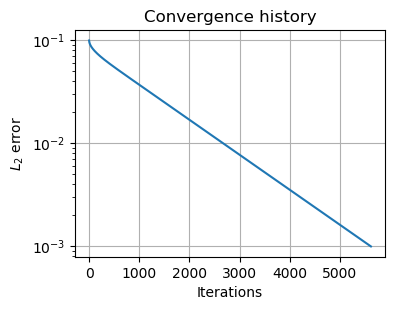

In [5]:
fig = plt.figure(figsize=(4,3), dpi=100)
plt.semilogy(L2norm[1:])
plt.ylabel('$L_2$ error')
plt.xlabel('Iterations')
plt.title('Convergence history')
plt.grid("both")

#### Variation in the centreline velocity with $N$

Now let's plot the variation in the centreline velocity ($w_{max}$) with $N$:

Text(0.5, 0, 'Number of cells, $N$')

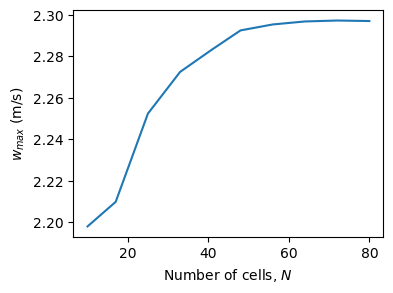

In [6]:
fig = plt.figure(figsize=(4,3), dpi=100)
plt.plot(N,wmax)
plt.ylabel('$w_{max}$ (m/s)')
plt.xlabel('Number of cells, $N$')

We see that the solution monotonically approaches a steady state. What happens if you solve the system for $N$ > 80? Why?

#### Plot the velocity contour:

Now we call our _plot2d_ sub-routine to plot the velocity contour:

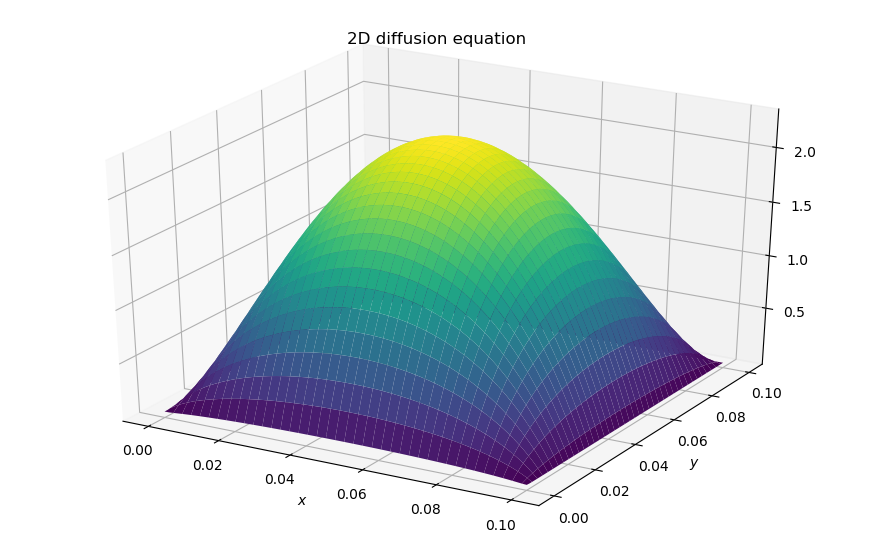

In [7]:
plot2d(np.linspace(0,h,N[-1]),np.linspace(0,h,N[-1]),w,'2D diffusion equation')

#### Validation against analytical results:

Finally, let's compare our results against the analytical solution for a channel with an _infinite spanwise width_. The analytical velocity profile (recall, we did this derivation in ENGR 310) is

\begin{equation}
w = \dfrac{1}{4\mu}\dfrac{dP}{dz}(y^2 - yh).
\end{equation}

Text(0.5, 1.0, 'Velocity profile at $y/h = 0.5$')

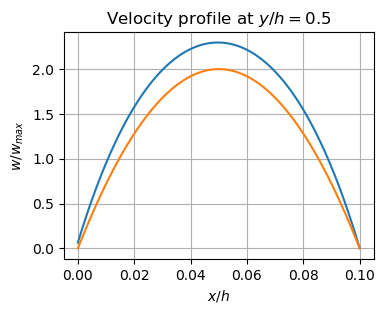

In [8]:
y = np.linspace(0,h,N[-1])
w_analytical = 1/(4*mu)*dPdz*(y**2 - y*h)

fig = plt.figure(figsize=(4,3), dpi=100)
plt.plot(y,w[int(N[-1]/2),:])
plt.plot(y,w_analytical)
plt.ylabel('$w/w_{max}$')
plt.xlabel('$x/h$')
plt.grid(which='both')
plt.title('Velocity profile at $y/h = 0.5$')

Notice the discrepancy between our numerical result and the analytical solution. Why do you think this discrepancy exists?